In [1]:
import json
from typing import Annotated
from typing_extensions import TypedDict
from dotenv import load_dotenv
from langchain_teddynote import logging
from langchain.embeddings import CacheBackedEmbeddings
from langchain.retrievers import EnsembleRetriever
from langchain.schema import Document
from langchain.storage import LocalFileStore
from langchain.text_splitter import CharacterTextSplitter
from langchain_community.retrievers import BM25Retriever
from langchain_community.vectorstores import FAISS
from langchain_upstage import UpstageEmbeddings
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.schema.output_parser import StrOutputParser
from langgraph.graph import StateGraph
from langgraph.graph import START, END
from langchain_teddynote.messages import display_message_tree
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.runnables import RunnableConfig
from langchain.schema.runnable import RunnablePassthrough, RunnableLambda 

In [7]:
load_dotenv()
logging.langsmith("langgraph_RAG")

memory = MemorySaver()
# LLM 초기화
llm = ChatOpenAI(model="gpt-4o-mini", streaming=True)

# State 정의
class State(TypedDict):
    # list 타입에 add_messages 적용(list 에 message 추가)
    messages: Annotated[list, add_messages]
    query : Annotated[str, "사용자의 질문"]
    intent: Annotated[str, "사용자의 의도"]
    keyword : Annotated[list, "주문의사가 있는 메뉴명"]
    context : Annotated[list, "질문과 연관된 문서"]
    next: Annotated[str, "다음 실행할 노드"]
    menu_list: Annotated[list,"전체 메뉴명 리스트"]
    order_done: Annotated[bool, "주문메뉴명 결정여부"]

def print_state(state: State, step_name: str = ""):
    """State의 현재 상태를 출력하는 함수"""
    print(f"\n{'='*20} State Status {'='*20}")
    if step_name:
        print(f"Step: {step_name}")
    print(f"\n1. Messages:")
    for msg in state.get("messages", []):
        if isinstance(msg, tuple):
            role, content = msg
            print(f"   - {role}: {content}")
        else:
            print(f"   - {msg}")
    
    print(f"\n2. Query: {state.get('query', 'Not set')}")
    print(f"\n3. Intent: {state.get('intent', 'Not set')}")
    
    print(f"\n4. Context:")
    for i, doc in enumerate(state.get("context", []), 1):
        print(f"   Document {i}:")
        print(f"   {doc}")
    print("="*50)

def classify_intent(state: State):
    """사용자의 의도를 분류하는 함수"""
    INTENT_PROMPT = PromptTemplate(
        template="""
        당신은 맥도날드 직원입니다. 고객의 질문에서 의도를 파악해주세요.

        [고객의 질문]: {query}

        가능한 의도:
        1. order: 메뉴 주문 또는 메뉴 추천 요청
        2. cancel: 주문 취소 요청
        3. other: 그 외 기타 문의

        다음 의도를 'order', 'cancel', 'other' 중 하나로만 답변하세요.
        """,
        input_variables=["query"]
    )
    
    chain = INTENT_PROMPT | llm | StrOutputParser()
    intent = chain.invoke({"query": state["query"]})
    
    return {"intent": intent.strip(), "next": intent.strip()}

def not_respond(state: State):
    """ 주문과 연관되지 않은 질의 시, 일괄답변"""
    response = "죄송하지만, 저는 주문만 도와드릴 수 있습니다. 해당 사항은 직원에게 문의해주세요. 혹시 오늘 드시고 싶은 메뉴가 있으신가요?"
    return {
            "messages": [("assistant", response)]
        }

def order_cancel(state: State):
    """ 주문을 취소하거나 수정을 원할 때"""
    response = "주문 취소나 수정을 원하는 메뉴명을 말씀해주세요"
    return {
        "messages": [("assistant", response)],
        "next": "end"
    }

def get_list():
    menu_list = []
    file_dir = "/home/yoojin/ML/aiffel/HackaThon/modu_hackaton/LLM/files/menu_1017.json"
    data = json.load(open(file_dir, 'r', encoding='utf-8'))
    for item in data:
        menu_name = item['page_content']['name']
        menu_list.append(menu_name)
    return menu_list
    
def extract_keyword(state: State):
    menu_list = get_list()
    template = PromptTemplate.from_template("""
        사용자의 질문과 메뉴 리스트를 비교하여 사용자의 질문과 비슷한 메뉴가 있는지 확인하세요.
        비슷한 이름의 메뉴가 있다면 비슷한 메뉴를 모두 출력하세요
        비슷한 메뉴가 없다면 "없음"이라고 출력하세요.
        출력 시 메뉴 이름만 출력하세요

        <메뉴 리스트>
        {menu_list}
        </메뉴 리스트>

        <질문>
        {question}
        </질문>

        """)
    
    name_chain = RunnableLambda(lambda inputs: {"menu_list": menu_list, "question": inputs}) | template | llm | StrOutputParser()
    result = name_chain.invoke(state["query"])
    
    if result.strip() == "없음":
        state["keyword"] = []
    else:
        state["keyword"] = result.strip().split("\n")
    
    return {
        "next": "fast_order" if state["keyword"] else "decide"
    }

def retriever_tool(query):
    file_dir = "/home/yoojin/ML/aiffel/HackaThon/modu_hackaton/LLM/files/menu_1017.json"

    docs = [
        Document(
            page_content=json.dumps(obj["page_content"], ensure_ascii=False),
        )
        for obj in json.load(open(file_dir, "r", encoding="utf-8"))
    ]

    text_splitter = CharacterTextSplitter(separator="\n\n", chunk_size=200, chunk_overlap=0)
    split_docs = text_splitter.split_documents(docs)

    embeddings = UpstageEmbeddings(model="solar-embedding-1-large")
    cache_dir = LocalFileStore(f"./.cache/embeddings/{file_dir.split('/')[-1]}")
    cached_embedder = CacheBackedEmbeddings.from_bytes_store(
        underlying_embeddings=embeddings,
        document_embedding_cache=cache_dir,
        namespace="solar-embedding-1-large",
    )

    vectorstore = FAISS.from_documents(split_docs, cached_embedder)

    faiss = vectorstore.as_retriever(search_kwargs={"k": 2})
    bm25 = BM25Retriever.from_documents(split_docs)
    bm25.k = 2
    
    ensemble_retriever = EnsembleRetriever(
        retrievers=[bm25, faiss],
        weights=[0.3, 0.7],
        search_type="mmr",
    )
    response = ensemble_retriever.invoke(query)
    return response

def format_docs(docs):
    if not docs:
        return "현재 가지고 있는 메뉴 정보가 없습니다."
    return "\n\n".join(doc.page_content for doc in docs)
    
def decide_next_step(state: State):
    """다음 단계를 결정하는 함수"""
    DECIDE_PROMPT = PromptTemplate(
        template="""
        당신은 맥도날드 직원입니다. 고객의 질문에 답변하기 위해 다음 중 어떤 행동을 해야할지 결정해주세요.

        [고객의 질문]: {query}
        [현재 가지고 있는 메뉴 정보]: {context}

        가능한 행동:
        1. retrieve: 메뉴 정보가 없거나 불충분하여 추가 검색이 필요할 때
        2. respond: 현재 가지고 있는 메뉴 정보로 충분히 답변할 수 있을 때

        다음 행동을 'retrieve' 또는 'respond' 중 하나로만 답변하세요.
        """,
        input_variables=["query", "context"]
    )
    
    context = format_docs(state.get("context", []))
    
    chain = DECIDE_PROMPT | llm | StrOutputParser()
    next_step = chain.invoke({"query": state["query"], "context": context})
    
    return {"next": next_step.strip()}

def retrieve(state: State):
    """메뉴 정보를 검색하는 함수"""
    retrieved_docs = retriever_tool(state["query"])
    return {"context": retrieved_docs, "next": "respond"}

def respond(state: State):
    """답변을 생성하는 함수"""
    REC_PROMPT = PromptTemplate(
        template="""
        당신은 맥도날드의 친절한 점원입니다.
        고객님의 주문을 도와드리세요. 모든 설명은 어린아이도 이해할 수 있게 해주세요. 
        대답은 세 문장 이내로, 간결하고 친절하게 응대합니다.
        
        [메뉴 정보] \n\n {context} \n\n
        [고객의 질문] {question} \n
        
        **Response Guidelines:**
        - 질문과 가장 관련성이 높은 정보를 선택해 대답하세요.
        - 메뉴 추천은 2개 이하로 제한하며, 신메뉴를 우선 추천하세요.
        - 확실하지 않으면 "정확한 답변을 드리기 어렵습니다만, 추가로 확인 후 도와드리겠습니다."라고 답하세요.
        - 사용자가 주문하고자 하는 메뉴가 정해지면, "[메뉴명] 주문을 도와드리겠습니다"라고 출력하세요. [메뉴명] 부분은 실제로 사용자가 정한 메뉴명으로 대체됩니다.

        """,
        input_variables=["context", "question"]
    )
    docs = format_docs(state["context"])
    chain = REC_PROMPT | llm | StrOutputParser()
    response = chain.invoke({"context": docs, "question": state["query"]})
    
    # 주문이 확정되었는지 확인
    order_done = "주문을 도와드리겠습니다" in response  # 예시 조건, 실제 조건에 맞게 수정 필요
    state['order_done'] = order_done
    
    return {
        "messages": [("assistant", response)],
        "next": "confirm" if state['order_done'] else "end"
    }

def confirm(state:State):
    """ 주문할 메뉴명 추출"""
    print(state["messages"])
    return {
    "next": "fast_order" if state["keyword"] else END
}

def fast_order(state:State):
    response = "빠른 주문 모듈 구축예정"
    return {
        "messages": [("assistant", response)]
    }

# 상태 그래프 초기화
workflow = StateGraph(State)

# 노드 추가
workflow.add_node("classify_intent", classify_intent)
workflow.add_node("not_respond", not_respond)
workflow.add_node("cancel", order_cancel)
workflow.add_node("keyword_LLM", extract_keyword)
workflow.add_node("decide", decide_next_step)
workflow.add_node("retrieve", retrieve)
workflow.add_node("respond", respond)
workflow.add_node("fast_order", fast_order)
workflow.add_node("confirm", confirm)

# 엣지 추가
workflow.add_edge(START, "classify_intent")
workflow.add_conditional_edges(
    "classify_intent",
    lambda x: x["intent"],
    {
        "order": "keyword_LLM",
        "cancel": "cancel",
        "other": "not_respond"
    }
)
workflow.add_edge("cancel", END)
workflow.add_edge("not_respond", END)
workflow.add_conditional_edges(
    "keyword_LLM",
    lambda x: x["next"],
    {
        "decide": "decide",
        "fast_order": "fast_order"
    }
)
workflow.add_conditional_edges(
    "decide",
    lambda x: x["next"],
    {
        "retrieve": "retrieve",
        "respond": "respond"
    }
)
workflow.add_edge("retrieve", "respond")
workflow.add_conditional_edges(
    "respond",
    lambda x: x["next"],
    {
        "confirm": "confirm",
        "end": END
    }
)
workflow.add_edge("confirm", "fast_order")
workflow.add_edge("fast_order", END)

# 그래프 컴파일
graph = workflow.compile(checkpointer=memory)


LangSmith 추적을 시작합니다.
[프로젝트명]
langgraph_RAG


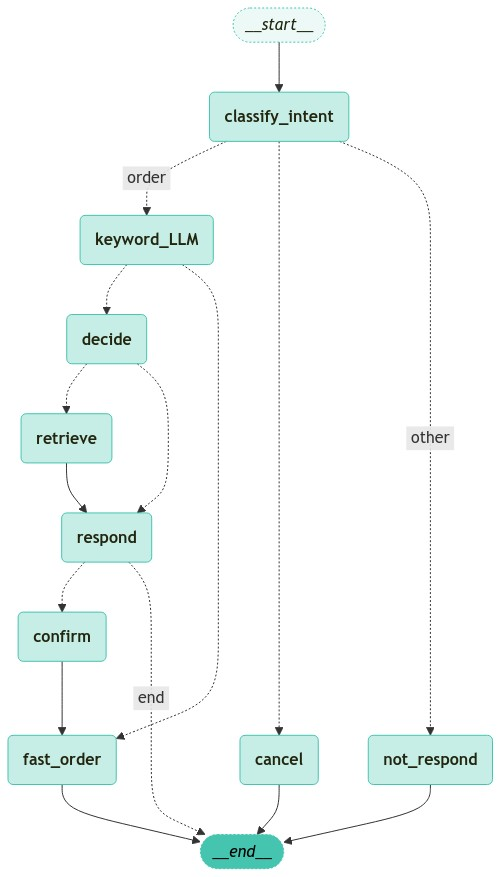

In [8]:
from langchain_teddynote.graphs import visualize_graph

# 그래프 시각화 및 PNG 파일로 저장
visualize_graph(graph)

In [6]:
config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
)

# 그래프 실행 시 query 포함
query = input("입력:")   ### STT연결
initial_state = {
    "messages": [("user", query)],
    "query": query,
}

# 초기 상태 출력
print_state(initial_state, "Initial State")

for event in graph.stream(initial_state,config=config):
    for key, value in event.items():
        print(f"\n==============\nSTEP: {key}\n==============\n")
        if "messages" in value and value["messages"]:
            last_message = value["messages"][-1]
            if isinstance(last_message, tuple):
                role, content = last_message
                print(f"{role}: {content}")
            else:
                print(last_message)
        
        # # chatbot node를 지난 후의 state 출력
        # print("\nState after chatbot:")
        # print_state(value, f"State after {key}")


==================== State Status ====================
Step: Initial State

1. Messages:
   - user: 맥크리스피 그걸로 줘

2. Query: 맥크리스피 그걸로 줘

3. Intent: Not set

4. Context:

STEP: classify_intent


STEP: keyword_LLM


STEP: fast_order

assistant: 빠른 주문 모듈 구축예정


In [5]:
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(
    configurable={"thread_id": "1"},  # 스레드 ID 설정
)
# 그래프 상태 스냅샷 생성
snapshot = graph.get_state(config)
snapshot.values["messages"]

[HumanMessage(content='매콤한거 먹고싶어', additional_kwargs={}, response_metadata={}, id='ddcde239-b509-4bda-a8a0-3383b8ce7cb1'),
 AIMessage(content='매콤한 걸 원하신다면 "맥크리스피 스리라차 마요 버거"와 "베토디 스리라차 마요 버거"를 추천해 드릴게요. 두 버거 모두 매콤한 소스가 들어가서 맛있답니다! 어떤 메뉴를 주문하시겠어요?', additional_kwargs={}, response_metadata={}, id='d6d941a6-df3f-48dd-b2b6-f9f99b95257d')]